In [20]:
import SimpleITK as sitk
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import copy
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.distributions import studentT, normal, beta, exponential
import sys
import torch.optim as optim
import cv2, os, math
from PIL import Image
import requests
import ast
import pandas as pd
import shutil, random
from itertools import product
import imageio
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
%matplotlib inline

### Create Train Test Split

In [11]:
#Split into train test folders

train_dir = 'train'
test_dir = 'test'
dirnames = ['hcc_images_1', 'mcrc_images_1']

for dirname in dirnames:
    os.mkdir("test/"+dirname)
    for path_dir, dirnames, filenames in os.walk(train_dir+"/"+dirname):
        test_quantity = int((len(filenames)/100)*15)
        random_select = random.sample(filenames, test_quantity)
        for file in random_select:
            shutil.move("train/"+dirname+"/"+file, "test/"+dirname+"/"+file)
    

### Define Image Transformations

In [2]:
TRANSFORM_IMG_TRAIN = transforms.Compose(
    [transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))])

TRANSFORM_IMG_TEST = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))])

TRAIN_DATA_PATH = "train"
TEST_DATA_PATH = "test"

batch_size = 32

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_TRAIN)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 285
    Root location: train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-360.0, 360.0], resample=False, expand=False)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
           )
Dataset ImageFolder
    Number of datapoints: 50
    Root location: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
           )


### Create a CNN Architecture

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, padding=1) #Channels in, Channels out, Filter size
        self.conv0_bn = nn.BatchNorm2d(16)      
        
        self.conv1 = nn.Conv2d(16, 32, 3, padding=1) #Channels in, Channels out, Filter size
        self.conv1_bn = nn.BatchNorm2d(32)  
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)  

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(128)  
        
        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8_bn = nn.BatchNorm2d(256)  
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully conected layers:
        self.fc15 = nn.Linear(25088, 4096)
        self.fc16 = nn.Linear(4096, 512)
        self.fc17 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(self.conv0_bn(x))
#         x = self.dropout(x)
        x= self.pool(x)
        
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
#         x = self.dropout(x)
        x= self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
#         x = self.dropout(x)
        x= self.pool(x)
        
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
#         x = self.dropout(x)   
        x = self.pool(x)

        x = x.reshape(-1, 25088)
        x = F.relu(self.fc15(x))
#         x = self.dropout(x)
        x = F.relu(self.fc16(x))
        x = self.fc17(x)
        return x

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002, weight_decay=1e-4)

### Train the CNN Classifier

In [6]:
train_loss=[]
val_loss=[]

for epoch in range(40):  
    count_t=0
    count_v=0
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        net.train()

        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count_t+=1
        
    train_loss.append(running_loss/count_t)
    print("Epoch ", epoch, "Train loss: ",running_loss/count_t)
            
    running_loss_v = 0.0     
    for i_v, data_v in enumerate(testloader, 0):
        net.eval()
        inputs_v, labels_v = data_v[0].to(device), data_v[1].to(device)

        outputs_v = net(inputs_v)
        loss_v = criterion(outputs_v, labels_v)

        running_loss_v += loss_v.item()
        count_v += 1 
        
    
    val_loss.append(running_loss_v/count_v)
    print("Epoch ", epoch, "Val loss: ",running_loss_v/count_v)
        
    if len(val_loss) == 1:
        print("Initial val loss saved")
        print("\n")
        torch.save(net.state_dict(), "weights4/liver.pth")
    else:
        if val_loss[-1] <= min(val_loss):
            print("Val loss saved")
            print("\n")
            torch.save(net.state_dict(), "weights4/liver_"+str(epoch)+"_.pth")
        else:
            print("\n")

print('Finished Training')


Epoch  0 Train loss:  1.111520767211914
Epoch  0 Val loss:  0.6567877531051636
Initial val loss saved


Epoch  1 Train loss:  0.560040510363049
Epoch  1 Val loss:  0.6439974159002304
Val loss saved


Epoch  2 Train loss:  0.5317329367001852
Epoch  2 Val loss:  0.6214427649974823
Val loss saved


Epoch  3 Train loss:  0.4454039732615153
Epoch  3 Val loss:  0.493734672665596
Val loss saved


Epoch  4 Train loss:  0.4755865799056159
Epoch  4 Val loss:  0.45806682854890823
Val loss saved


Epoch  5 Train loss:  0.4544871946175893
Epoch  5 Val loss:  0.4014962911605835
Val loss saved


Epoch  6 Train loss:  0.41517339481247795
Epoch  6 Val loss:  0.39867787063121796
Val loss saved


Epoch  7 Train loss:  0.4672280268536674
Epoch  7 Val loss:  0.43961162865161896


Epoch  8 Train loss:  0.45149733622868854
Epoch  8 Val loss:  0.4566602110862732


Epoch  9 Train loss:  0.4262602627277374
Epoch  9 Val loss:  0.4650753438472748


Epoch  10 Train loss:  0.41355007390181225
Epoch  10 Val loss:  0

### Plot Loss Graphs

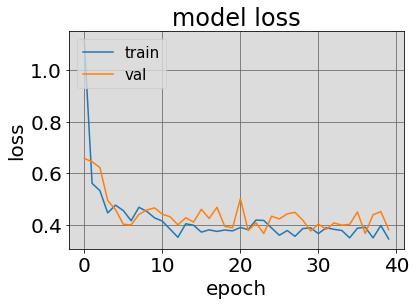

In [91]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epoch', fontsize = 20)
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.grid(color='dimgray')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('lossy_gray.png', bbox_inches='tight')

### Find Model Accuracy

In [13]:
# since we're not training, we don't need to calculate the gradients for our outputs
net1_loaded = Net()
net1_loaded.cuda()
net1_loaded.load_state_dict(torch.load("weights4/liver_23_.pth"))

correct=0
total=0 

net1_loaded.eval()
# random.seed(0)
outputs = 0
with torch.no_grad():
    for data in testloader:
        #print(data[1])
        images, labels = data[0].to(device), data[1].to(device)
        
        # calculate outputs by running images through the network
        
        outputs = net1_loaded(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        print("Predicted")
        print(predicted)
        print("Labels")
        print(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test images: %d %%' % (100 * correct / total))

Predicted
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Labels
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted
tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Labels
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Accuracy on test images: 80 %


### Find classifier performance scores and confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(labels, pred_labels))
cm = confusion_matrix(labels, pred_labels)
cm

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        23
           1       0.84      0.78      0.81        27

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50



array([[19,  4],
       [ 6, 21]], dtype=int64)